In [3]:
import os
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
os.chdir("C:/Users/Strahinja/Desktop/Project for Data analysis/data-analytics-project/data")

In [4]:
def import_dataset(filename):
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    bank_mkt = bank_mkt.sample(frac = 1) 
    return bank_mkt

def tree_encode(X):
    """
    Encode categorical data into numerical values.
    pdays column will be feature engineered and discretized.
    """
    X = X.copy()
    # pdays column will be feature engineered and discretized.
    X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
    X["pdays"] = pd.cut(X["pdays"], [0, 5, 10, 15, 30, 1000], labels=[1, 2, 3, 4, 5], include_lowest=True).astype("Int64")
    # Encode nominal and ordinal features
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3,
                 "apr": 4,
                 "jun": 5,
                 "jul": 6,
                 "may": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("int")
    # Other categorical features will be coded as its order in pandas categorical index
    cat_features = ["job", "education", "marital", "contact", "day_of_week"]
    bool_features = ["default", "housing", "loan", "poutcome"]
    X[cat_features] = X[cat_features].apply(lambda x: x.cat.codes).astype("Int64")
    X[bool_features] = X[bool_features].astype("Int64")
    # Fill missing values as -1
    X = X.fillna(-1)
    return X

tree_encoder = FunctionTransformer(tree_encode)

# Features with missing values that should be imputed with most freq value
freq_features = ["job", "marital", "default", "housing", "loan"]

# tree_imputer will impute missing values in columns specified by freq_features
tree_imputer = ColumnTransformer([
    ("freq_imputer",
     SimpleImputer(missing_values=-1,strategy="most_frequent"),
     freq_features)],
    remainder="passthrough")

# Wrap tree_encoder and tree_imputer in one pipeline
tree_preprocessor = Pipeline([
    ("basic_encoder", tree_encoder),
    ("tree_imputer", tree_imputer)])

In [5]:
bank_mkt = import_dataset("BankMarketing.csv")
bank_mkt.info()
bank_mkt.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 34863 to 10825
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  Int64   
 1   job             40858 non-null  category
 2   marital         41108 non-null  category
 3   education       39457 non-null  category
 4   default         32591 non-null  boolean 
 5   housing         40198 non-null  boolean 
 6   loan            40198 non-null  boolean 
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  Int64   
 11  campaign        41188 non-null  Int64   
 12  pdays           1515 non-null   Int64   
 13  previous        41188 non-null  Int64   
 14  poutcome        5625 non-null   boolean 
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.con

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
34863,28,blue-collar,married,basic.9y,False,True,False,cellular,may,fri,115,5,<NA>,0,<NA>,-1.8,92.893,-46.2,1.250,5099.1,False
31161,30,blue-collar,married,basic.9y,False,False,False,cellular,may,wed,129,1,<NA>,0,<NA>,-1.8,92.893,-46.2,1.334,5099.1,False
36314,28,self-employed,single,university.degree,False,True,True,cellular,jun,mon,187,2,<NA>,0,<NA>,-2.9,92.963,-40.8,1.266,5076.2,False
27713,70,retired,divorced,basic.4y,False,True,False,cellular,mar,mon,187,3,<NA>,0,<NA>,-1.8,92.843,-50.0,1.811,5099.1,True
38767,65,retired,single,university.degree,False,False,False,cellular,nov,thu,253,1,<NA>,2,False,-3.4,92.649,-30.1,0.714,5017.5,True


In [6]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in train_test_split.split(bank_mkt.drop("y", axis=1), bank_mkt["y"]):
    bank_train_set = bank_mkt.loc[train_index].reset_index(drop=True)
    bank_test_set = bank_mkt.loc[test_index].reset_index(drop=True)

In [19]:
X_train = tree_preprocessor.fit_transform(bank_train_set.drop(["duration", "y"], axis=1))
y_train = bank_train_set["y"].astype("int").to_numpy()

from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=42,class_weight="balanced",criterion ="gini",max_features="auto", 
                           min_samples_split= 2)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth':[6,8,10],
    'n_estimators':[1000,1500,1750,2000]
}
CV_RFmodel = GridSearchCV(estimator=RF,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.46101896083896854, for RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1500,
                       random_state=42)


In [8]:
y_test = bank_test_set["y"].astype("int").to_numpy()
X_test = tree_preprocessor.transform(bank_test_set.drop(["duration", "y"], axis=1))

train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in train_validate_split.split(X_train, y_train):
    X_ttrain = X_train[train_index]
    y_ttrain = y_train[train_index]
    X_validate = X_train[test_index]
    y_validate = y_train[test_index]




RF_validation = RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=6,n_estimators=1500,
                                       max_leaf_nodes=1000)
RF_fit = RF_validation.fit(X_ttrain, y_ttrain)

X_sets = [X_ttrain, X_validate, X_test]
y_sets = [y_ttrain, y_validate, y_test]

matric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
set_names = ["Train", "Validation", "Test"]
matric_df = pd.DataFrame(index=matric_names, columns=set_names)

for name, X, y in zip(set_names, X_sets, y_sets):
    y_pred = RF_validation.predict(X)
    y_score = RF_validation.predict_proba(X)[:,1]
    matrics = [recall_score(y, y_pred, pos_label=0),
               recall_score(y, y_pred),
               balanced_accuracy_score(y, y_pred),
               roc_auc_score(y, y_score),
               recall_score(y, y_pred),
               precision_score(y, y_pred),
               f1_score(y, y_pred),
               average_precision_score(y, y_score)]
    matric_df[name] = matrics

matric_df


,Train,Validation,Test
TNR,0.870305,0.865035,0.872448
TPR,0.626801,0.634595,0.592119
bACC,0.748553,0.749815,0.732284
ROC,0.818259,0.795774,0.790840
REC,0.626801,0.634595,0.592119
PRE,0.379498,0.372935,0.373907
F1,0.472762,0.469788,0.458368
AP,0.512891,0.447884,0.458924


In [9]:
columns = bank_train_set.drop(["duration", "y"], axis=1).columns.tolist()
rnd_clf = RandomForestClassifier(n_estimators=1750,max_depth=6, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
for name, importance in zip(columns, rnd_clf.feature_importances_):
    print(name, "=", importance)

age = 0.005318709730052927
job = 0.0032283459419663466
marital = 1.962391531748617e-08
education = 0.0016923784556616664
default = 0.0015466224826179954
housing = 0.023405619636046142
loan = 0.005891481331971973
contact = 0.017745324139464388
month = 0.030886343397778574
day_of_week = 0.009189907732605933
campaign = 0.00815846429064134
pdays = 0.03797015147062547
previous = 0.023062423051796697
poutcome = 0.1397408073745672
emp.var.rate = 0.08445578032649204
cons.price.idx = 0.06038263945526357
cons.conf.idx = 0.08315426812165776
euribor3m = 0.2190410622256826
nr.employed = 0.24512965121119204


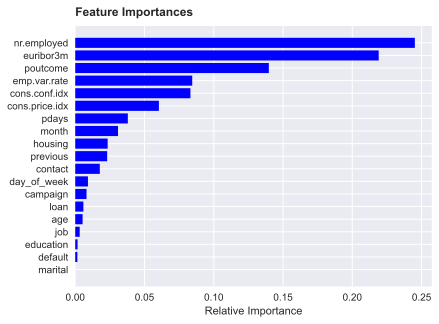

In [10]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("Feature importance.png")
plt.size=(15,10)
plt.show()


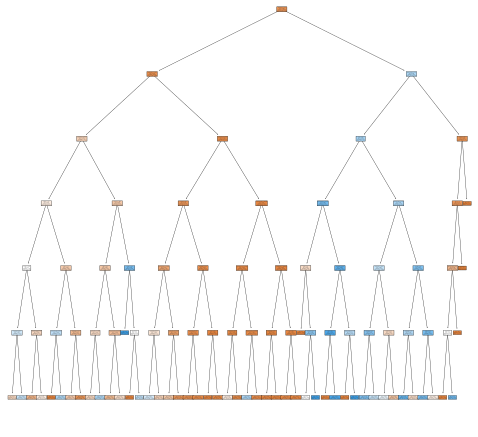

In [11]:
from sklearn import tree
import matplotlib.pyplot as plt
fn= columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
tree.plot_tree(rnd_clf.estimators_[0],
               feature_names = fn,
               filled = True,
              proportion=True);
fig.savefig('rf_individualtree.png')

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [13]:
X_train = tree_preprocessor.fit_transform(bank_train_set.drop(["duration", "y"], axis=1))
y_train = bank_train_set["y"].astype("int").to_numpy()

AB= AdaBoostClassifier(n_estimators=100,random_state=42,learning_rate=1.0)

from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate':[0.8],
    'n_estimators':[800],
    'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=4)]
}
CV_RFmodel = GridSearchCV(estimator=AB,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.45322103045583806, for AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.8, n_estimators=800, random_state=42)


In [16]:
y_test = bank_test_set["y"].astype("int").to_numpy()
X_test = tree_preprocessor.transform(bank_test_set.drop(["duration", "y"], axis=1))

train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in train_validate_split.split(X_train, y_train):
    X_ttrain = X_train[train_index]
    y_ttrain = y_train[train_index]
    X_validate = X_train[test_index]
    y_validate = y_train[test_index]




AB_validation = AdaBoostClassifier(n_estimators=800,learning_rate=0.8,random_state=42,
                                       base_estimator = DecisionTreeClassifier(max_depth=2,min_samples_split=2))
AB_fit = AB_validation.fit(X_ttrain, y_ttrain)

X_sets = [X_ttrain, X_validate, X_test]
y_sets = [y_ttrain, y_validate, y_test]

matric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
set_names = ["Train", "Validation", "Test"]
matric_df = pd.DataFrame(index=matric_names, columns=set_names)

for name, X, y in zip(set_names, X_sets, y_sets):
    y_pred = AB_validation.predict(X)
    y_score = AB_validation.predict_proba(X)[:,1]
    matrics = [recall_score(y, y_pred, pos_label=0),
               recall_score(y, y_pred),
               balanced_accuracy_score(y, y_pred),
               roc_auc_score(y, y_score),
               recall_score(y, y_pred),
               precision_score(y, y_pred),
               f1_score(y, y_pred),
               average_precision_score(y, y_score)]
    matric_df[name] = matrics

matric_df

,Train,Validation,Test
TNR,0.985982,0.972650,0.979312
TPR,0.393448,0.262162,0.272630
bACC,0.689715,0.617406,0.625971
ROC,0.878366,0.743267,0.757640
REC,0.393448,0.262162,0.272630
PRE,0.780308,0.548023,0.628993
F1,0.523125,0.354662,0.380386
AP,0.632423,0.374018,0.423666


In [15]:
columns = bank_train_set.drop(["duration", "y"], axis=1).columns.tolist()
AB_influence = AB= AdaBoostClassifier(n_estimators=800,learning_rate=0.8,random_state=42)
for name, importance in zip(columns, rnd_clf.feature_importances_):
    print(name, "=", importance)

age = 0.005318709730052927
job = 0.0032283459419663466
marital = 1.962391531748617e-08
education = 0.0016923784556616664
default = 0.0015466224826179954
housing = 0.023405619636046142
loan = 0.005891481331971973
contact = 0.017745324139464388
month = 0.030886343397778574
day_of_week = 0.009189907732605933
campaign = 0.00815846429064134
pdays = 0.03797015147062547
previous = 0.023062423051796697
poutcome = 0.1397408073745672
emp.var.rate = 0.08445578032649204
cons.price.idx = 0.06038263945526357
cons.conf.idx = 0.08315426812165776
euribor3m = 0.2190410622256826
nr.employed = 0.24512965121119204


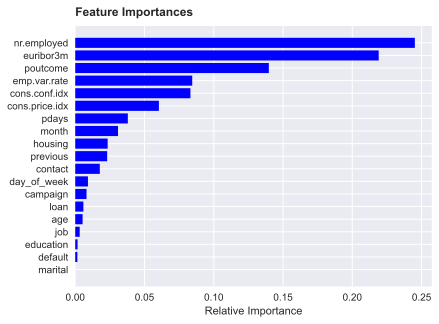

In [17]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("Feature importance.png")
plt.size=(15,10)
plt.savefig("Feature importance_ada.png")
plt.show()